# Todos
- [x] add todo (jupyter notebook tutorial)
- [x] ipdb on exception
- [x] clean code: remove argparse, run by calling function with suitable arguments
-  ~~write evaluation of upper bound performance of an abstraction~~ (This is useless since when there are 40 abstraction states, the number of policy is $4^{40}$, impossible to find out the best one)
- [x] generate abstractions with different n_goal and n_abs, select some of them to do multi-task training and transfer
    - run 12 tasks on identity map
    - run 12 tasks on 12-44 pos abstract map
    - run 1 task on 12-44 pos abstract map
- [x] vanilla alternative training for prob and vq
- [x] try window size = 1 (otherwise it is impossible to visualize abs)
    - [ ] why it does not work?
- [x] try to log text on the config: including git code
- [x] visualization of abs at each step
- [ ] try nonlinear actor for vq
- [x] change critic to abstract state critic
- [ ] implement sampling abs_encoder
- [ ] try I2A modeling
- [ ] get rid of the time stamp in tf_log
- [ ] make plots for all log with same attrubites
    
# Readings
- [ ] POMDP
- [ ] soft actor-critic
- [ ] Representation learning for RL (alternative training, meta-learning for $\phi$?)

# Settings and Functions

Automatic pdb calling has been turned ON
# of shown colors: 45/47


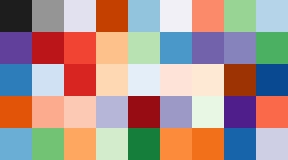

In [3]:
%pdb on

from deep_rl.gridworld import ReachGridWorld, PORGBEnv, ReachGoalManager
import os
import sys 
import random
import argparse
import dill
import json
import itertools
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from collections import Counter, namedtuple
from IPython.display import display
from PIL import Image
from pathlib import Path

def seed(s):
    random.seed(s)
    np.random.seed(s)

seed(0) # set seed 

class one_hot:
    # 1 or 2 dim
    @staticmethod
    def encode(indices, dim):
        if len(indices.shape) > 1:
            indices = indices.squeeze(axis=1)
        assert len(indices.shape) == 1, 'shape error'
        return np.eye(dim)[indices]

    # 2-dim
    @staticmethod
    def decode(vs):
        return np.argmax(vs, 1)

def fload(fn, ftype):
    if ftype == 'json':
        with open(fn) as f:
            return json.load(f)
    elif ftype == 'pkl':
        with open(fn, 'rb') as f:
            return dill.load(f)
    elif ftype == 'png':
        raise NotImplementedError
    else:
        raise Exception('cannot read this data type: {}'.format(ftype))
    
def fsave(data, fn, ftype):
    dirname = os.path.dirname(fn)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    if ftype == 'json':
        with open(fn, 'w') as f:
            json.dump(data, f)
    elif ftype == 'pkl':
        with open(fn, 'wb') as f:
            dill.dump(data, f)    
    elif ftype == 'png':
        Image.fromarray(data).save(fn)
    else:
        raise Exception('unsupported file type: {}'.format(ftype))

def index_dict(l):
    l = list(enumerate(set(l)))
    i2e = dict(l)
    e2i = dict([(e, i) for i, e in l])
    return i2e, e2i
        
# input: a index map
# output: a new index map such that the index are contiguous
def index_reduce(index_map):
    _, i2i = index_dict(index_map.values())
    return {k: i2i[i] for k, i in index_map.items()}

# given a 2d list, concatenate each row by dim 1, and each column by dim 0
def concat2d(arr2d):
    return np.concatenate([np.concatenate(arr, axis=1) for arr in arr2d])

def imshow(img):
    display(Image.fromarray(img))

class GridDrawer:                           
    def __init__(self, color_list):
        self.color_list = np.asarray(color_list)

    # input: a 2-d index matrix
    # output: a 2-d rgb matrix
    def draw(self, indices, repeat=16):
        return np.uint8(255 * np.array(self.color_list[indices, :]).repeat(repeat, 0).repeat(repeat, 1))
    
# this is my color list
color_map = dict([
    #*[('grey-{}'.format(v), plt.cm.Greys(0.1 * v)) for v in range(1, 10)],
    *[('purple-{}'.format(v), plt.cm.Purples(0.1 * v)) for v in range(1, 10)],
    *[('blue-{}'.format(v), plt.cm.Blues(0.1 * v)) for v in range(1, 10)],
    *[('green-{}'.format(v), plt.cm.Greens(0.1 * v)) for v in range(1, 10)],
    *[('orange-{}'.format(v), plt.cm.Oranges(0.1 * v)) for v in range(1, 10)],
    *[('red-{}'.format(v), plt.cm.Reds(0.1 * v)) for v in range(1, 10)],
])

color_list = list(color_map.values())
shuffle(color_list)
color_list = [plt.cm.Greys(0.9)] + [plt.cm.Greys(0.5)] + color_list
visualization_map = dict([
    ('G', 0),
    ('#', 1),
    *[(str(i), i + 2) for i in range(0, 45)],
])

def display_color_list(color_list):
    drawer = GridDrawer(color_list=color_list)
    n_shown_color = 45
    n_row = 5
    print('# of shown colors: {}/{}'.format(n_shown_color, len(drawer.color_list)))
    grid = np.arange(n_shown_color).reshape((n_row, n_shown_color // n_row))
    img = Image.fromarray(drawer.draw(grid, repeat=32))
    display(img)

display_color_list(color_list)
    
def cluster_abstraction(env, n_abs, feature_type='whole'):
    from sklearn.cluster import KMeans
    n_action = env.action_space.n
    env.reset()
    states = get_states(env)
    m = [[] for _ in range(len(states))]
    for combo in env.train_combos:
        env.reset(index=combo)
        for i, s in enumerate(states):
            env.teleport(*s)
            qs = np.array(env.get_q(0.99))
            best_actions = (qs == qs.max()).astype(int)
            if feature_type == 'whole':
                m[i].append(best_actions)
            elif feature_type == 'sample':
                sample_action = np.random.choice(np.argwhere(best_actions).squeeze(1), size=1)
                sample_action = one_hot.encode(sample_action, n_action)[0]
                m[i].append(sample_action)
            else:
                raise Exception('invalid feature type')
    m = np.array([np.concatenate(row) for row in m])
    kmeans = KMeans(n_clusters=n_abs, random_state=0).fit(m)
    abs_map = {s: label for s, label in zip(states, kmeans.labels_)}
    return abs_map

def get_abs_map(env, n_abs=40, method='cluster', method_config=dict()):
    # abs_map {(x, y): abstract state index}
    if method == 'cluster':
        abs_map = cluster_abstraction(env, n_abs, **method_config)
    else:
        raise Exception('no such method')
    return abs_map

GoalConfig = namedtuple('GoalConfig', ['map_name', 'n_goal', 'min_dis'])

def gen_multigoal_combos(goal_config):
    MAX_GOAL_NUM = 15
    goal_manager = ReachGoalManager(goal_config.map_name)
    # min_dis between goals (approximation of corelation)
    goals = goal_manager.gen_goals(MAX_GOAL_NUM + 1, min_dis=goal_config.min_dis) 
    train_combos = [(0,) + goal for goal in goals[:goal_config.n_goal]]
    test_combos = [(0,) + goals[-1]]
    return train_combos, test_combos

def gen_multigoal_env(goal_config):
    train_combos, test_combos = gen_multigoal_combos(goal_config)
    return ReachGridWorld([goal_config.map_name], train_combos, test_combos)

def get_abs_img(abs_map, env):
    m = env.get_map(0)
    print('labels:', set(abs_map.values()))
    print('count on labels:', Counter(abs_map.values()))
    for i in range(len(m)):
        for j in range(len(m[i])):
            if m[i][j] == '#': continue
            elif (i, j) in abs_map:
                m[i][j] = str(abs_map[(i, j)])
            else:
                m[i][j] = 'G'
    drawer = GridDrawer(color_list)
    img = drawer.draw([[visualization_map[m[i][j]] for j in range(len(m[i]))] for i in range(len(m))])
    return img
    
def save_abs(abs_dict, fn):
    with open(os.path.join('data/abs', fn), 'wb') as f:
        dill.dump(abs_dict, f)
    
def load_abs(fn):
    with open(os.path.join('data/abs', fn), 'rb') as f:
        return dill.load(fn)
    
# get all goals in train_combos
def get_goals(env, train=True):
    combos = env.unwrapped.train_combos if train else env.unwrapped.test_combos
    return [env.unwrapped.i2g[combo[1]] for combo in combos]
    
# input: an single map multigoal environment
# output: position of all states that are not goal states
def get_states(env):
    goals = get_goals(env)
    return [s for s in env.unwrapped.pos_candidates if s not in goals]

def kv2str(items, is_dict=True):
    if is_dict:
        items = list(items.items())
    return '-'.join(['{}-{}'.format(*item) for item in items])

def get_abs_fn(method, method_config, n_goal, n_abs):
    return '{}-{}-n_goal-{}-n_abs-{}.pkl'.format(
                                            method,
                                            kv2str(method_config),
                                            n_goal,
                                            n_abs)

# Procedures

In [4]:
# input: an environment and the corresponding index (map_id, gx, gy)
# output: an identity map of this map_id and task
def gen_identity_map(map_name):
    train_combos = [(0, 1, 1)]
    test_combos = [(0, 2, 2)]
    env = ReachGridWorld([map_name], train_combos, test_combos)
    env.reset()
    states = [s for s in env.pos_candidates] + list(env.train_pos)
    print(states)
    n_states = len(states)
    id_map = dict([(s, i) for i, s in enumerate(states)])
    save_abs({0: id_map}, '{}-id.pkl'.format(map_name))

# get abstraction map by a chosen method
# specify the number of abstract states, number of goals and the minimum distance between goal states
def gen_abs_map(goal_config, n_abs=40, method='cluster', method_config=dict()):
    env = gen_multigoal_env(goal_config)
    abs_map = get_abs_map(env, n_abs=n_abs, method=method, method_config=method_config)
    imshow(gen_abs_img(abs_map, env))
    save_abs({0: abs_map}, get_abs_fn(method, method_config, goal_config.n_goal, n_abs))
    print('save abs_map to {}'.format(abs_fn))

def gen_abs_maps(n_goal_range, n_abs_range, method, method_config=dict()):
    abs_maps = [[] for _ in n_goal_range] # n_goal x n_abs
    for i, n_goal in enumerate(n_goal_range):
        goal_config = GoalConfig('map49', n_goal=n_goal, min_dis=4)
        env = gen_multigoal_env(goal_config)
        for n_abs in n_abs_range:
            goal_map = {g: n_abs + i for i, g in enumerate(env.unwrapped.train_pos)}
            abs_map = get_abs_map(env, n_abs=n_abs, method=method, method_config=method_config)
            abs_maps[i].append(abs_map)
            saved_map = {**abs_map, **goal_map}
            fn = get_abs_fn(method, method_config, n_goal, n_abs)
            save_abs({0: saved_map}, fn)
            print('saved to {}'.format(fn))
    abs_maps = concat2d([[get_abs_img(abs_map, env) for abs_map in row] for row in abs_maps])
    imshow(abs_maps)
    Image.fromarray(abs_maps).save('data/abs/abs_mat.png')

def gen_single_env_config(map_name, goal):
    train_combos = [(0,) + goal]
    test_combos = [(0, 1, 1)]
    env_config = dict(
        map_names=[map_name],
        train_combos=train_combos,
        test_combos=test_combos,
        min_dis=10,
    )
    fn = 'data/env_configs/map49-{}-{}'.format(*goal)
    fsave(env_config, fn, ftype='pkl')
    print('{} saved'.format(fn))
    
def gen_env_config(goal_config, min_dis):
    train_combos, test_combos = gen_multigoal_combos(goal_config)
    env_config = dict(
        map_names=[goal_config.map_name],
        train_combos=train_combos,
        test_combos=test_combos,
        min_dis=min_dis,
    )
    fn = '{}-n_goal-{}-min_dis-{}'.format(goal_config.map_name, goal_config.n_goal, goal_config.min_dis)
    with open('data/env_configs/{}'.format(fn), 'wb') as f:
        dill.dump(env_config, f)
        print('generate env_config: {}'.format(fn))

# add more attributes to env_config for all env_config in env_configs
def modify_env_configs():
    for fn in os.listdir('data/env_configs'):
        env_config = fload(fn, ftype='pkl')
        env_config['window'] = 1
        fsave(env_config, fn, ftype='pkl')
        
# given a directory of pkl of abs_map, output the img of the abs
def gen_abs_imgs(dirname, redo=False):
    env_config = fload(os.path.join(dirname, 'env_config'), ftype='pkl')
    env = ReachGridWorld(**env_config)
    for fn in os.listdir(Path(dirname, 'abs_map')):
        save_fp = Path(dirname, 'abs_img', Path(fn).with_suffix('.png'))
        if save_fp.exists() and not redo: continue
        print(fn)
        abs_map = fload(Path(dirname, 'abs_map', fn), ftype='pkl')
        abs_map = index_reduce(abs_map)
        img = get_abs_img(abs_map, env)
        fsave(img, save_fp, ftype='png')
        
if __name__ == '__main__':
    seed(0)
    gen_abs_imgs('tf_log/tsa-prob-map49-single-n_abs-256-test-190105-145708')
#     modify_env_configs()
#     gen_single_env_config('map49', (1, 14))
    
#     gen_identity_map('map49')
    
#     gen_env_config(
#         GoalConfig(
#             map_name='map49',
#             n_goal=12,
#             min_dis=4,
#         ),
#         min_dis=10,
#     )

#     gen_abs_maps(
#         n_goal_range=list(range(1, 16)),
#         n_abs_range=[4 * i for i in range(1, 12)],
#         method='cluster',
#         method_config=dict(feature_type='whole'),
#     )
    
#     gen_abs_map(
#         GoalConfig(
#             map_name='map49',
#             n_goal=10,
#             min_dis=4,
#         ),
#         n_abs=10,
#         method='cluster',
#         method_config=dict(feature_type='whole'),
#     )

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
train: [(0, 0)]
test: [(0, 1)]
3082240.pkl
1314816.pkl
4419584.pkl
5368832.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 83, 0: 48, 2: 20})
2037760.pkl
4574208.pkl
6504448.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 60, 1: 57, 2: 34})
5570560.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 54, 0: 50, 2: 47})
714752.pkl
3969024.pkl
5242880.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 52, 2: 51, 0: 48})
3461120.pkl
4501504.pkl
5257216.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 54, 1: 51, 0: 46})
4780032.pkl
3451904.pkl
5445632.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 64, 0: 47, 2: 40})
5518336.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 59, 0: 49, 2: 43})
1723392.pkl
2937856.pkl
6459392.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 61, 1: 58, 2: 32})
6010880.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 57, 0: 48, 

379904.pkl
1177600.pkl
6064128.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 78, 0: 47, 2: 26})
3241984.pkl
3135488.pkl
2745344.pkl
121856.pkl
3332096.pkl
6532096.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 62, 1: 54, 2: 35})
3924992.pkl
208896.pkl
3633152.pkl
397312.pkl
5777408.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 55, 1: 52, 0: 44})
2155520.pkl
671744.pkl
1207296.pkl
4071424.pkl
655360.pkl
1984512.pkl
5536768.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 56, 2: 50, 0: 45})
2621440.pkl
3773440.pkl
5454848.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 51, 0: 50, 2: 50})
5748736.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 58, 2: 49, 0: 44})
406528.pkl
1479680.pkl
2422784.pkl
1742848.pkl
4654080.pkl
4026368.pkl
1503232.pkl
940032.pkl
736256.pkl
2398208.pkl
4063232.pkl
2085888.pkl
6479872.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 60, 1: 55, 2: 36})
809984.pkl
5306368.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 65, 0: 45, 2: 41})
62

labels: {0, 1, 2}
count on labels: Counter({1: 58, 0: 48, 2: 45})
2896896.pkl
687104.pkl
4750336.pkl
5963776.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 53, 2: 52, 0: 46})
4447232.pkl
5769216.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 54, 2: 53, 0: 44})
1628160.pkl
2919424.pkl
1650688.pkl
2110464.pkl
6235136.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 54, 2: 51, 0: 46})
2529280.pkl
1352704.pkl
490496.pkl
6157312.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 56, 2: 50, 0: 45})
4784128.pkl
4563968.pkl
1916928.pkl
5006336.pkl
2760704.pkl
5637120.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 60, 0: 57, 2: 34})
3294208.pkl
3289088.pkl
3151872.pkl
5681152.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 82, 0: 45, 2: 24})
4571136.pkl
883712.pkl
2766848.pkl
3579904.pkl
575488.pkl
2353152.pkl
439296.pkl
933888.pkl
3136512.pkl
2407424.pkl
4035584.pkl
3232768.pkl
3866624.pkl
3457024.pkl
2205696.pkl
5351424.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 79, 0

5269504.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 74, 0: 44, 2: 33})
3789824.pkl
5143552.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 58, 2: 49, 0: 44})
1351680.pkl
1624064.pkl
3758080.pkl
3434496.pkl
6308864.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 60, 0: 47, 2: 44})
2030592.pkl
5929984.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 55, 1: 51, 0: 45})
429056.pkl
796672.pkl
2394112.pkl
768000.pkl
2540544.pkl
817152.pkl
3391488.pkl
2092032.pkl
5719040.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 88, 0: 40, 2: 23})
2681856.pkl
3338240.pkl
656384.pkl
1330176.pkl
5945344.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 54, 1: 53, 0: 44})
6071296.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 73, 0: 51, 2: 27})
4626432.pkl
3986432.pkl
5089280.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 86, 0: 44, 2: 21})
811008.pkl
2926592.pkl
190464.pkl
1485824.pkl
4672512.pkl
1411072.pkl
10240.pkl
2283520.pkl
2052096.pkl
2610176.pkl
4250624.pkl
4460544.pkl
3

1149952.pkl
154624.pkl
2434048.pkl
1652736.pkl
1032192.pkl
1843200.pkl
4978688.pkl
5692416.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 81, 0: 44, 2: 26})
4615168.pkl
5041152.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 76, 0: 43, 2: 32})
4573184.pkl
2670592.pkl
5752832.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 57, 2: 49, 0: 45})
1544192.pkl
4889600.pkl
1634304.pkl
2856960.pkl
3022848.pkl
2539520.pkl
3741696.pkl
403456.pkl
1383424.pkl
2747392.pkl
5981184.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 55, 1: 52, 0: 44})
1735680.pkl
5850112.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 54, 2: 51, 0: 46})
5452800.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 57, 2: 48, 0: 46})
4618240.pkl
5913600.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 53, 0: 49, 1: 49})
712704.pkl
4122624.pkl
6470656.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 62, 1: 55, 2: 34})
4923392.pkl
4402176.pkl
5163008.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 56, 2: 5

1478656.pkl
652288.pkl
3728384.pkl
3328000.pkl
6132736.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 71, 0: 48, 2: 32})
807936.pkl
3106816.pkl
625664.pkl
1510400.pkl
234496.pkl
3126272.pkl
679936.pkl
1466368.pkl
2964480.pkl
5029888.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 81, 0: 44, 2: 26})
3802112.pkl
2853888.pkl
3392512.pkl
5784576.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 54, 1: 53, 0: 44})
825344.pkl
3620864.pkl
311296.pkl
751616.pkl
1186816.pkl
2387968.pkl
385024.pkl
873472.pkl
5054464.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 65, 0: 49, 2: 37})
3836928.pkl
3991552.pkl
6341632.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 72, 1: 58, 2: 21})
1243136.pkl
5552128.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 59, 0: 51, 2: 41})
3750912.pkl
253952.pkl
6134784.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 70, 0: 48, 2: 33})
4708352.pkl
4459520.pkl
5254144.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 53, 2: 50, 0: 48})
4925440.pkl
235

6124544.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 52, 2: 50, 0: 49})
2774016.pkl
1869824.pkl
5383168.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 69, 0: 47, 2: 35})
561152.pkl
3807232.pkl
1377280.pkl
5381120.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 70, 0: 46, 2: 35})
2249728.pkl
3138560.pkl
2788352.pkl
2183168.pkl
3813376.pkl
3197952.pkl
1724416.pkl
5508096.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 58, 0: 51, 2: 42})
4585472.pkl
6032384.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 76, 0: 46, 2: 29})
2724864.pkl
4061184.pkl
1812480.pkl
6118400.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 54, 2: 49, 0: 48})
5016576.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 89, 0: 42, 2: 20})
4439040.pkl
5735424.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 70, 2: 41, 0: 40})
2350080.pkl
2775040.pkl
3458048.pkl
6359040.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 72, 1: 53, 2: 26})
1254400.pkl
4232192.pkl
45056.pkl
3159040.pkl
3582976.pkl
3

count on labels: Counter({1: 63, 0: 49, 2: 39})
2140160.pkl
1590272.pkl
1746944.pkl
5081088.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 57, 0: 47, 2: 47})
5636096.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 60, 0: 54, 2: 37})
4008960.pkl
4259840.pkl
580608.pkl
3093504.pkl
2450432.pkl
3368960.pkl
6152192.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 54, 2: 51, 0: 46})
5303296.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 59, 2: 50, 0: 42})
1704960.pkl
6204416.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 56, 0: 50, 2: 45})
292864.pkl
850944.pkl
5295104.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 56, 2: 51, 0: 44})
3240960.pkl
420864.pkl
5226496.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 59, 2: 49, 0: 43})
4054016.pkl
69632.pkl
2135040.pkl
4074496.pkl
5458944.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 53, 0: 51, 2: 47})
1820672.pkl
6445056.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 67, 1: 57, 2: 27})
2214912.pkl
3059712.pkl
1477

labels: {0, 1, 2}
count on labels: Counter({2: 53, 1: 52, 0: 46})
1819648.pkl
38912.pkl
4028416.pkl
4662272.pkl
4869120.pkl
2281472.pkl
4773888.pkl
5338112.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 79, 0: 47, 2: 25})
3565568.pkl
5560320.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 70, 0: 48, 2: 33})
468992.pkl
2696192.pkl
2327552.pkl
5482496.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 58, 2: 47, 0: 46})
3668992.pkl
252928.pkl
1507328.pkl
4937728.pkl
5132288.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 74, 0: 44, 2: 33})
3771392.pkl
5304320.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 61, 2: 46, 0: 44})
5859328.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 56, 2: 49, 0: 46})
6328320.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 66, 1: 57, 2: 28})
5074944.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 51, 0: 50, 1: 50})
2383872.pkl
1562624.pkl
1592320.pkl
2019328.pkl
2973696.pkl
5176320.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 63,

2998272.pkl
5928960.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 55, 1: 52, 0: 44})
1284096.pkl
2663424.pkl
1961984.pkl
735232.pkl
4885504.pkl
944128.pkl
3892224.pkl
2100224.pkl
522240.pkl
4299776.pkl
872448.pkl
1874944.pkl
5988352.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 55, 2: 52, 0: 44})
4628480.pkl
1087488.pkl
5415936.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 68, 0: 43, 2: 40})
1856512.pkl
729088.pkl
2607104.pkl
2286592.pkl
2267136.pkl
3691520.pkl
2290688.pkl
6258688.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 62, 0: 46, 2: 43})
2451456.pkl
5419008.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 68, 0: 45, 2: 38})
4332544.pkl
2233344.pkl
1363968.pkl
6546432.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 60, 1: 56, 2: 35})
6281216.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 57, 2: 49, 0: 45})
4433920.pkl
3857408.pkl
1800192.pkl
360448.pkl
2000896.pkl
5149696.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 61, 2: 46, 0: 44})
2215936.pk

4290560.pkl
120832.pkl
26624.pkl
678912.pkl
2955264.pkl
2136064.pkl
3982336.pkl
1417216.pkl
5715968.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 98, 0: 40, 2: 13})
6167552.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 55, 2: 49, 0: 47})
2677760.pkl
5870592.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 54, 2: 51, 0: 46})
4500480.pkl
449536.pkl
4391936.pkl
4851712.pkl
3955712.pkl
1712128.pkl
4787200.pkl
175104.pkl
4676608.pkl
1683456.pkl
5318656.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 82, 0: 45, 2: 24})
381952.pkl
922624.pkl
1947648.pkl
3781632.pkl
1451008.pkl
5793792.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 55, 2: 52, 0: 44})
4246528.pkl
2632704.pkl
5137408.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 72, 0: 45, 2: 34})
886784.pkl
4579328.pkl
5816320.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 53, 0: 50, 1: 48})
4328448.pkl
5110784.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 88, 0: 44, 2: 19})
371712.pkl
5569536.pkl
labels: {0, 1,

labels: {0, 1, 2}
count on labels: Counter({2: 52, 1: 50, 0: 49})
1977344.pkl
3174400.pkl
2338816.pkl
3169280.pkl
1693696.pkl
1602560.pkl
3302400.pkl
6090752.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 77, 0: 51, 2: 23})
1235968.pkl
1522688.pkl
5796864.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 55, 2: 53, 0: 43})
2942976.pkl
1350656.pkl
74752.pkl
1187840.pkl
1068032.pkl
3902464.pkl
5820416.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 54, 0: 50, 1: 47})
628736.pkl
6436864.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 68, 1: 61, 2: 22})
1371136.pkl
6161408.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 55, 2: 51, 0: 45})
325632.pkl
5817344.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 53, 0: 50, 1: 48})
3038208.pkl
1201152.pkl
404480.pkl
846848.pkl
4249600.pkl
334848.pkl
4508672.pkl
1557504.pkl
1298432.pkl
3522560.pkl
4346880.pkl
4824064.pkl
1615872.pkl
2846720.pkl
831488.pkl
1497088.pkl
1277952.pkl
6300672.pkl
labels: {0, 1, 2}
count on labels: Counter

211968.pkl
4350976.pkl
3562496.pkl
3935232.pkl
4580352.pkl
2278400.pkl
2442240.pkl
4761600.pkl
3108864.pkl
2829312.pkl
3143680.pkl
728064.pkl
4600832.pkl
686080.pkl
1893376.pkl
189440.pkl
4120576.pkl
5417984.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 73, 0: 45, 2: 33})
1440768.pkl
5622784.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 98, 0: 46, 2: 7})
5399552.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 52, 1: 52, 2: 47})
1386496.pkl
3074048.pkl
3663872.pkl
1336320.pkl
6521856.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 64, 1: 55, 2: 32})
64512.pkl
4172800.pkl
4846592.pkl
6398976.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 68, 1: 59, 2: 24})
156672.pkl
1393664.pkl
1772544.pkl
2825216.pkl
5634048.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 70, 0: 52, 2: 29})
1429504.pkl
3800064.pkl
2116608.pkl
1533952.pkl
496640.pkl
2560000.pkl
3202048.pkl
5314560.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 80, 0: 45, 2: 26})
1559552.pkl
2360320.pkl
5266432

labels: {0, 1, 2}
count on labels: Counter({0: 68, 1: 61, 2: 22})
2157568.pkl
4816896.pkl
4082688.pkl
3351552.pkl
4216832.pkl
1500160.pkl
6098944.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 53, 0: 50, 2: 48})
6543360.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 60, 1: 54, 2: 37})
662528.pkl
3980288.pkl
6172672.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 56, 2: 49, 0: 46})
5970944.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 51, 2: 51, 0: 49})
2811904.pkl
1160192.pkl
3988480.pkl
5320704.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 73, 0: 47, 2: 31})
2707456.pkl
1245184.pkl
6317056.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 62, 0: 49, 2: 40})
1406976.pkl
4634624.pkl
5714944.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 96, 0: 40, 2: 15})
3423232.pkl
3033088.pkl
2308096.pkl
2277376.pkl
5018624.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 88, 0: 41, 2: 22})
303104.pkl
4987904.pkl
6524928.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 6

labels: {0, 1, 2}
count on labels: Counter({1: 80, 0: 44, 2: 27})
3587072.pkl
4089856.pkl
6252544.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 62, 0: 46, 2: 43})
1397760.pkl
6419456.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 63, 1: 58, 2: 30})
1346560.pkl
2381824.pkl
2950144.pkl
3644416.pkl
6020096.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 66, 0: 50, 2: 35})
5142528.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 60, 0: 47, 2: 44})
5668864.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 82, 0: 46, 2: 23})
6318080.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 60, 0: 48, 2: 43})
5794816.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 55, 2: 52, 0: 44})
304128.pkl
3585024.pkl
6197248.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 57, 0: 47, 2: 47})
1420288.pkl
3954688.pkl
1278976.pkl
2816000.pkl
5235712.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 66, 0: 45, 2: 40})
3610624.pkl
6348800.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 75, 1:

5877760.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 53, 2: 53, 0: 45})
2415616.pkl
5680128.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 81, 0: 45, 2: 25})
1519616.pkl
828416.pkl
3889152.pkl
5484544.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 66, 0: 44, 2: 41})
5121024.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 80, 0: 49, 2: 22})
2027520.pkl
1850368.pkl
243712.pkl
4093952.pkl
3076096.pkl
5344256.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 78, 0: 45, 2: 28})
1418240.pkl
1729536.pkl
5411840.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 55, 0: 48, 2: 48})
1537024.pkl
4757504.pkl
1541120.pkl
5566464.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 63, 0: 49, 2: 39})
4942848.pkl
3694592.pkl
179200.pkl
249856.pkl
899072.pkl
1198080.pkl
4630528.pkl
4174848.pkl
3411968.pkl
2626560.pkl
3079168.pkl
5280768.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 56, 2: 50, 0: 45})
2578432.pkl
159744.pkl
4813824.pkl
5058560.pkl
labels: {0, 1, 2}
count on labels:

6433792.pkl
labels: {0, 1, 2}
count on labels: Counter({0: 68, 1: 60, 2: 23})
5297152.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 55, 1: 50, 0: 46})
985088.pkl
507904.pkl
5961728.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 54, 1: 52, 0: 45})
6110208.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 52, 2: 50, 0: 49})
5525504.pkl
labels: {0, 1, 2}
count on labels: Counter({2: 51, 0: 50, 1: 50})
1546240.pkl
2104320.pkl
5657600.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 68, 0: 43, 2: 40})
947200.pkl
3345408.pkl
447488.pkl
3803136.pkl
794624.pkl
4621312.pkl
992256.pkl
5009408.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 104, 0: 39, 2: 8})
6016000.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 64, 0: 49, 2: 38})
1818624.pkl
577536.pkl
4687872.pkl
5489664.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 59, 2: 47, 0: 45})
5435392.pkl
labels: {0, 1, 2}
count on labels: Counter({1: 59, 0: 47, 2: 45})
4361216.pkl
6073344.pkl
labels: {0, 1, 2}
count on labels: 

# Debug

{(1, 2): 35,
 (1, 3): 35,
 (1, 4): 35,
 (1, 5): 35,
 (1, 6): 35,
 (1, 7): 35,
 (1, 8): 35,
 (1, 9): 35,
 (1, 11): 35,
 (1, 12): 35,
 (1, 13): 35,
 (1, 14): 35,
 (2, 1): 35,
 (2, 2): 35,
 (2, 3): 35,
 (2, 4): 35,
 (2, 6): 35,
 (2, 7): 35,
 (2, 8): 35,
 (2, 9): 35,
 (2, 11): 35,
 (2, 12): 35,
 (2, 13): 35,
 (2, 14): 35,
 (3, 1): 35,
 (3, 2): 35,
 (3, 3): 35,
 (3, 4): 35,
 (3, 6): 35,
 (3, 7): 35,
 (3, 8): 35,
 (3, 9): 35,
 (3, 11): 35,
 (3, 12): 35,
 (3, 13): 35,
 (3, 14): 35,
 (4, 1): 35,
 (4, 2): 35,
 (4, 3): 35,
 (4, 4): 35,
 (4, 6): 35,
 (4, 7): 35,
 (4, 8): 35,
 (4, 9): 35,
 (4, 11): 35,
 (4, 12): 35,
 (4, 13): 35,
 (4, 14): 35,
 (5, 1): 35,
 (5, 8): 35,
 (5, 14): 35,
 (6, 1): 35,
 (6, 2): 35,
 (6, 3): 35,
 (6, 4): 35,
 (6, 6): 35,
 (6, 7): 35,
 (6, 8): 35,
 (6, 9): 35,
 (6, 11): 35,
 (6, 12): 35,
 (6, 13): 35,
 (6, 14): 35,
 (7, 1): 35,
 (7, 2): 35,
 (7, 3): 35,
 (7, 4): 35,
 (7, 6): 35,
 (7, 7): 35,
 (7, 8): 35,
 (7, 9): 35,
 (7, 11): 35,
 (7, 12): 35,
 (7, 13): 35,
 (7, 14): 35,
